# Model deploymeny with Tensorflow Serving


## Step 1: Install libraries and dependencies


In [1]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2943  100  2943    0     0   4414      0 --:--:-- --:--:-- --:--:--  4418
OK
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [457 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-upd

In [2]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 438 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.13.0 [438 MB]
Fetched 438 MB in 26s (17.0 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 120511 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.13.0_all.deb ...
Unpacking tensorflow-model-server (2.13.0) ...
Setting up tensorflow-model-server (2.13.0) ...


In [ ]:
#!pip install tensorflow-gpu==1.13.1

In [3]:
!pip install requests

## Step 2: Import library dependencies

In [4]:
import os
import json
import random
import requests
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

%matplotlib inline
tf.__version__

'2.12.0'

## Step 3: Deta preprocessing

### Load the dataset

In [5]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [6]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Image processing, Normalization

In [7]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [8]:
X_train.shape

(50000, 32, 32, 3)

## Step4: Define the model

We are going to use a CNN, classify the images

In [9]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

### Compile the model

In [10]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

###  Train the model

In [11]:
model.fit(X_train,
          y_train,
          batch_size=128,
          epochs=10)

Epoch 1/10
391/391 [==============================] - 18s 11ms/step - loss: 1.5018 - sparse_categorical_accuracy: 0.4597
Epoch 2/10
391/391 [==============================] - 5s 13ms/step - loss: 1.0134 - sparse_categorical_accuracy: 0.6451
Epoch 3/10
391/391 [==============================] - 4s 11ms/step - loss: 0.8234 - sparse_categorical_accuracy: 0.7109
Epoch 4/10
391/391 [==============================] - 4s 11ms/step - loss: 0.7139 - sparse_categorical_accuracy: 0.7507
Epoch 5/10
391/391 [==============================] - 4s 10ms/step - loss: 0.6222 - sparse_categorical_accuracy: 0.7818
Epoch 6/10
391/391 [==============================] - 4s 10ms/step - loss: 0.5403 - sparse_categorical_accuracy: 0.8108
Epoch 7/10
391/391 [==============================] - 4s 11ms/step - loss: 0.4657 - sparse_categorical_accuracy: 0.8369
Epoch 8/10
391/391 [==============================] - 4s 11ms/step - loss: 0.3941 - sparse_categorical_accuracy: 0.8619
Epoch 9/10
391/391 [===================

### Evaluate the model

In [12]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.8915 - sparse_categorical_accuracy: 0.7515


In [13]:
print("La precisión del modelo es de {} %".format(test_accuracy*100.0))

La precisión del modelo es de 75.15000104904175 %


## Step 5: Save the modelfor deployment

### Make a directory for the model

In [14]:
MODEL_DIR = "model/"
version = 1

In [15]:
export_path = os.path.join(MODEL_DIR, str(version))
export_path

'model/1'

In [16]:
if os.path.isdir(export_path):
    !rm -r {export_path}

### Save the model for TensorFlow Serving

In [17]:
#tf.saved_model.simple_save(tf.keras.backend.get_session(), export_dir=export_path, inputs={"input_image":model.input}, outputs={t.name:t for t in model.outputs})
#tf.saved_model.save(model, export_path )
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = model/1




Saved model:
total 240
drwxr-xr-x 2 root root   4096 Aug 11 09:12 assets
-rw-r--r-- 1 root root     56 Aug 11 09:12 fingerprint.pb
-rw-r--r-- 1 root root  21578 Aug 11 09:12 keras_metadata.pb
-rw-r--r-- 1 root root 208509 Aug 11 09:12 saved_model.pb
drwxr-xr-x 2 root root   4096 Aug 11 09:12 variables


## Step 6: Configure the deployment environment

### Export MODEL_DIR into env variables

In [18]:
os.environ['MODEL_DIR'] = os.path.abspath(MODEL_DIR)

### Run the API REST of TensorFlow Serving

In [19]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8000 \
  --model_name=cifar10 \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [20]:
!tail server.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


## Step 7: Send the first request

In [21]:
random_image = np.random.randint(0, len(X_test))
random_image

7231

### Create the JSON object

In [22]:
data = json.dumps({"signature_name":"serving_default", "instances":[X_test[random_image].tolist()]})

In [23]:
data

'{"signature_name": "serving_default", "instances": [[[[0.7490196078431373, 0.9176470588235294, 0.9882352941176471], [0.7529411764705882, 0.9215686274509803, 0.9803921568627451], [0.7568627450980392, 0.9294117647058824, 0.9803921568627451], [0.7568627450980392, 0.9333333333333333, 0.9725490196078431], [0.7647058823529411, 0.9372549019607843, 0.9764705882352941], [0.7725490196078432, 0.9450980392156862, 0.9882352941176471], [0.7725490196078432, 0.9450980392156862, 0.9882352941176471], [0.7764705882352941, 0.9490196078431372, 0.9882352941176471], [0.7764705882352941, 0.9529411764705882, 0.9882352941176471], [0.7803921568627451, 0.9529411764705882, 0.9882352941176471], [0.788235294117647, 0.9568627450980393, 0.984313725490196], [0.792156862745098, 0.9568627450980393, 0.984313725490196], [0.792156862745098, 0.9607843137254902, 0.984313725490196], [0.796078431372549, 0.9607843137254902, 0.9882352941176471], [0.796078431372549, 0.9607843137254902, 0.9882352941176471], [0.792156862745098, 0.9

### Send the first POST request to the model

In [24]:
headers = {"content-type":"application/json"}

In [25]:
json_response = requests.post(url="http://localhost:8000/v1/models/cifar10:predict", data=data, headers=headers)

In [26]:
json_response

<Response [200]>

In [27]:
predictions = json.loads(json_response.text)['predictions']

In [28]:
predictions

[[0.355138779,
  8.66662685e-06,
  6.1688268e-05,
  0.000222047587,
  1.10368101e-05,
  1.20088043e-05,
  9.29935231e-06,
  4.60764e-05,
  0.644414365,
  7.60504263e-05]]

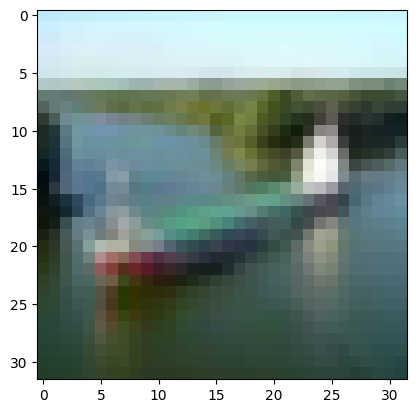

In [29]:
plt.imshow(X_test[random_image])

In [30]:
class_names[np.argmax(predictions[0])]

'ship'

## Step 8: Send a POST request to an specific model

In [31]:
specific_json_response = requests.post(url="http://localhost:8000/v1/models/cifar10/versions/1:predict", data=data, headers=headers)

In [32]:
specific_json_response

<Response [200]>